In [16]:
using QuantumOptics
using Plots
using Arpack
using ArnoldiMethod
using DelimitedFiles
using LaTeXStrings
using LinearAlgebra
using Statistics
using PyPlot

### Set up the basis
We start by setting up the basis. We have `Nparticles` living on `Nsites`, and we use the QuantumOptics function `NLevelBasis()` to account for our sites. Each site is one level, which can be occupied by as many particles as we want (since we're dealing with bosons). For the basis size this is a little troublesome, since it leads to a large number of basis states. 

In [132]:
Nsites = 6                             # Actual number of physical sites is half this, we encode particle types at different sites
Nparticles = 6                      # To define the rotated state we initially need double the number of particles
a = NLevelBasis(Nsites)
a_mb = ManyBodyBasis(a, bosonstates(a, Nparticles))

ManyBody(onebodybasis=NLevel(N=6), states:462)

In [135]:
Dim=size(a_mb.occupations)[1] # Dimension of the Hilbert Space
init=zeros(ComplexF64, Dim);
init[176]=1;
psi0=Ket(a_mb,init);
a_mb.occupations[176]

6-element Vector{Int64}:
 1
 1
 1
 1
 1
 1

### Set up the Hamiltonian
The Hamiltonian contains two terms, a tunneling term, and an on-site interaction term, respectively. If we express all energies in units of the tunneling rate $t$ the only free parameter is the on-site interaction $U$:
$$
    \mathcal{H} = -\sum_{\langle i,j \rangle} \hat{a}^\dagger_i \hat{a}_j + \frac{U}{2} \sum_i \hat{n}_i \left( \hat{n}_i - 1 \right)
$$
How do we convert this into a Hamiltonian we can solve numerically? In principle, we can define the creation and annihilation operators using the `create()` and `destroy()` functions QuantumOptics gives us, but constructing those involves the full many-body basis, while these are only single-particle operators. In some cases we found it numerically favorable to first define single-particle tunneling operators using the `transition()` function, which describes a transition from one level (i.e. site) to another. This single-particle operator can be converted to act on the many-body basis using the `manybodyoperator()` function.

For adding the on-site term we just use the `number()` functions. Note that all of these operators are nothing but fancy matrices, packaged in an efficient way and tagged with some information such as which basis they act on. This prevents one from accidentally using a Hamiltonian matrix and state vector belonging to different bases.

In [136]:
single_tunnel = [transition(a, i, i + 1) for i in 1 : (Nsites - 1)]
#single_tunnel = vcat(single_tunnel, transition(a,Nsites,1))
single_tunnel = [dagger.(single_tunnel); single_tunnel]
total_tunnel_s = sum([manybodyoperator(a_mb, t) for t in single_tunnel]);
onsite_interaction = sum( [ number(a_mb, i) * (number(a_mb, i) - identityoperator(a_mb)) for i in 1:Nsites ] );

In [137]:
H = -total_tunnel_s + 2/2 * onsite_interaction;

In [138]:
tspan = [0:0.01:10;]
tout, ψt = timeevolution.schroedinger(tspan, psi0, H);

In [139]:
i=3
Δn = real.(expect(number(a_mb, i)^2, ψt) - expect(number(a_mb, i), ψt).^2) ;

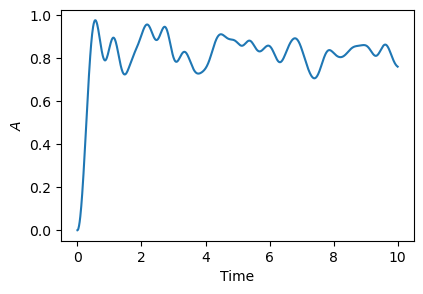

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000001823B20>

In [140]:
figure(figsize=[10, 3])

subplot(1, 2, 1)
xlabel("Time")
ylabel(L"$A$")
PyPlot.plot(tout, Δn)


In [143]:
numlist=[[] for i in 1:(Nparticles+1)]
for i in 1:Dim
    push!(numlist[a_mb.occupations[i][3]+1],i)  # We care about the 3rd atom in the whole chain.
end
numlist

7-element Vector{Vector{Any}}:
 [1, 2, 4, 5, 6, 7, 9, 10, 11, 16  …  453, 454, 455, 456, 457, 458, 459, 460, 461, 462]
 [3, 8, 13, 14, 15, 23, 28, 29, 30, 41  …  425, 426, 427, 428, 429, 430, 431, 432, 433, 434]
 [12, 27, 38, 39, 40, 62, 73, 74, 75, 96  …  404, 405, 406, 407, 408, 409, 410, 411, 412, 413]
 [37, 72, 93, 94, 95, 142, 163, 164, 165, 201  …  389, 390, 391, 392, 393, 394, 395, 396, 397, 398]
 [92, 162, 198, 199, 200, 288, 324, 325, 326, 383, 384, 385, 386, 387, 388]
 [197, 323, 380, 381, 382]
 [379]

In [174]:
Prob_list=[zeros(Nparticles+1) for i in 1:length(tout)]
for ti in 1:length(tout)
    for i in 1:(Nparticles+1)
        Prob_list[ti][i]=sum([abs(ψt[ti].data[j])^2 for j in numlist[i] ])
    end
end

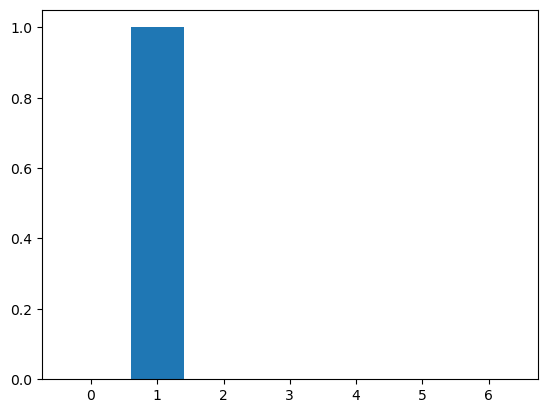

(PyObject <matplotlib.patches.Rectangle object at 0x00000000DBFB67A0>, PyObject <matplotlib.patches.Rectangle object at 0x00000000DBFB5780>, PyObject <matplotlib.patches.Rectangle object at 0x00000000DBFB6C50>, PyObject <matplotlib.patches.Rectangle object at 0x00000000DBFB6E90>, PyObject <matplotlib.patches.Rectangle object at 0x00000000DBFB70A0>, PyObject <matplotlib.patches.Rectangle object at 0x00000000DBFB72B0>, PyObject <matplotlib.patches.Rectangle object at 0x00000000DBFB74C0>)

In [191]:
PyPlot.bar([0,1,2,3,4,5,6],Prob_list[2^0])

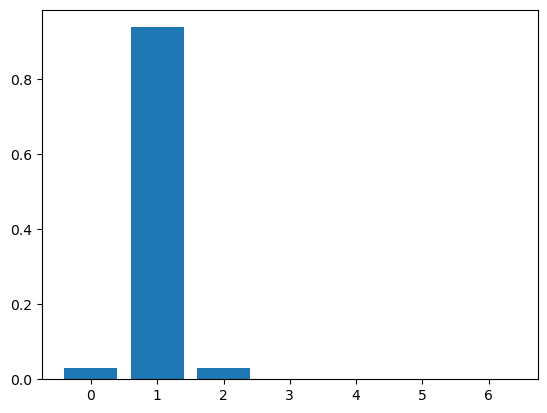

(PyObject <matplotlib.patches.Rectangle object at 0x00000000DC093070>, PyObject <matplotlib.patches.Rectangle object at 0x00000000DC092050>, PyObject <matplotlib.patches.Rectangle object at 0x00000000DC093550>, PyObject <matplotlib.patches.Rectangle object at 0x00000000DC093760>, PyObject <matplotlib.patches.Rectangle object at 0x00000000DC093970>, PyObject <matplotlib.patches.Rectangle object at 0x00000000DC093B80>, PyObject <matplotlib.patches.Rectangle object at 0x00000000DC093D90>)

In [193]:
PyPlot.bar([0,1,2,3,4,5,6],Prob_list[10])

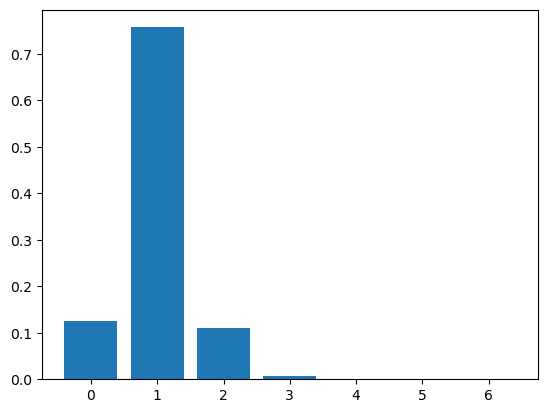

(PyObject <matplotlib.patches.Rectangle object at 0x00000000DC2DC4F0>, PyObject <matplotlib.patches.Rectangle object at 0x00000000DC2B3370>, PyObject <matplotlib.patches.Rectangle object at 0x00000000DC2DC9A0>, PyObject <matplotlib.patches.Rectangle object at 0x00000000DC2DCBB0>, PyObject <matplotlib.patches.Rectangle object at 0x00000000DC2DCDC0>, PyObject <matplotlib.patches.Rectangle object at 0x00000000DC2DCFD0>, PyObject <matplotlib.patches.Rectangle object at 0x00000000DC2DD1E0>)

In [195]:
PyPlot.bar([0,1,2,3,4,5,6],Prob_list[20])

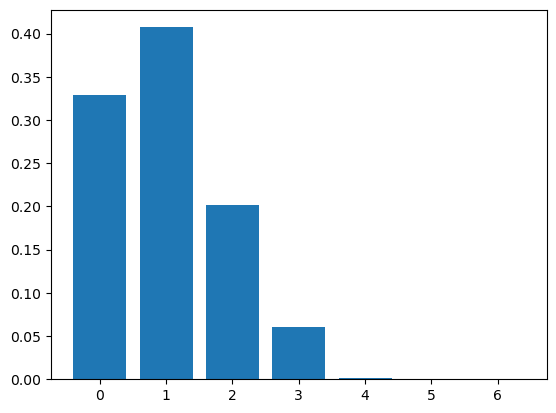

(PyObject <matplotlib.patches.Rectangle object at 0x00000000DC471510>, PyObject <matplotlib.patches.Rectangle object at 0x00000000DC471480>, PyObject <matplotlib.patches.Rectangle object at 0x00000000DC4719C0>, PyObject <matplotlib.patches.Rectangle object at 0x00000000DC471BD0>, PyObject <matplotlib.patches.Rectangle object at 0x00000000DC471DE0>, PyObject <matplotlib.patches.Rectangle object at 0x00000000DC471FF0>, PyObject <matplotlib.patches.Rectangle object at 0x00000000DC472200>)

In [196]:
PyPlot.bar([0,1,2,3,4,5,6],Prob_list[40])

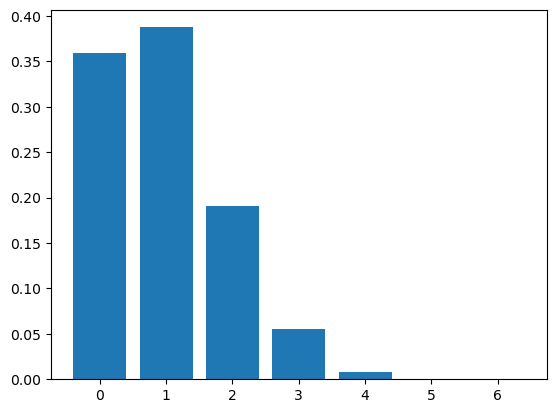

(PyObject <matplotlib.patches.Rectangle object at 0x00000000DC4DAAA0>, PyObject <matplotlib.patches.Rectangle object at 0x00000000DC4DAA10>, PyObject <matplotlib.patches.Rectangle object at 0x00000000DC4DAF50>, PyObject <matplotlib.patches.Rectangle object at 0x00000000DC4DB160>, PyObject <matplotlib.patches.Rectangle object at 0x00000000DC4DB370>, PyObject <matplotlib.patches.Rectangle object at 0x00000000DC4DB580>, PyObject <matplotlib.patches.Rectangle object at 0x00000000DC4DB790>)

In [197]:
PyPlot.bar([0,1,2,3,4,5,6],Prob_list[100])

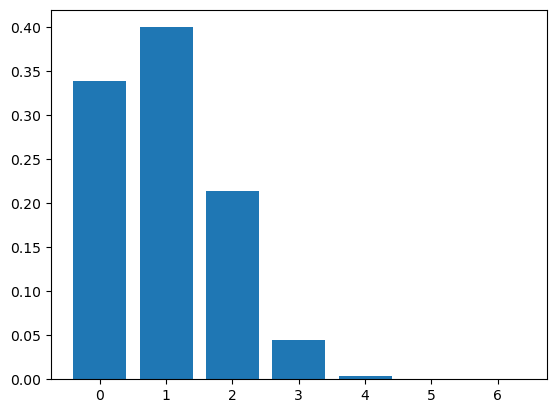

(PyObject <matplotlib.patches.Rectangle object at 0x00000000DC344070>, PyObject <matplotlib.patches.Rectangle object at 0x00000000DC317FA0>, PyObject <matplotlib.patches.Rectangle object at 0x00000000DC344520>, PyObject <matplotlib.patches.Rectangle object at 0x00000000DC344730>, PyObject <matplotlib.patches.Rectangle object at 0x00000000DC344940>, PyObject <matplotlib.patches.Rectangle object at 0x00000000DC344B50>, PyObject <matplotlib.patches.Rectangle object at 0x00000000DC344D60>)

In [198]:
PyPlot.bar([0,1,2,3,4,5,6],Prob_list[1000])